# Imports & Constants

In [146]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [147]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

Text(0.5, 1.0, 'Mask')

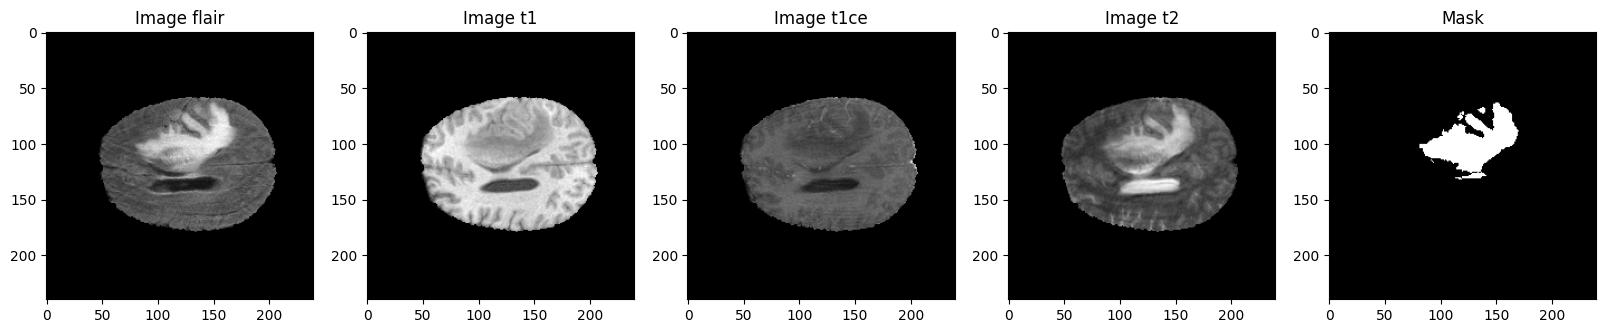

In [148]:
TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
TRAIN_DATASET_PATH_P = 'data/Processed_Data'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_002/BraTS20_Training_002_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w], cmap = 'gray')
ax5.set_title('Mask')


# Pre-processing

# Split processed data into train, test and validation

In [150]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
TRAIN_DATASET_PATH_P = 'data/Processed_Data'

os.makedirs(TRAIN_DATASET_PATH_P, exist_ok=True)
for folder in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(TRAIN_DATASET_PATH_P, folder), exist_ok=True)

def preprocess_dataset(dataset_path, new_dataset_path):
    seg_slice_idx = 80
    folder_names = os.listdir(dataset_path)
    train_names, test_names = train_test_split(folder_names, test_size=0.2, random_state=42)
    train_names, val_names = train_test_split(train_names, test_size=0.1, random_state=42)
    
    for folder_name in folder_names:
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            flair_path = os.path.join(folder_path, f'{folder_name}_flair.nii')
            seg_path = os.path.join(folder_path, f'{folder_name}_seg.nii')
            if os.path.exists(flair_path) and os.path.exists(seg_path):
                flair_array = np.rot90(nib.load(flair_path).get_fdata(), 1)[:, :, seg_slice_idx]
                seg_array = np.rot90(nib.load(seg_path).get_fdata(), 1)[:, :, seg_slice_idx]
                folder_type = 'train' if folder_name in train_names else 'test' if folder_name in test_names else 'validation'
                folder_path = os.path.join(new_dataset_path, folder_type, folder_name[-3:])
                os.makedirs(folder_path, exist_ok=True)
                plt.imsave(os.path.join(folder_path, 'flair.jpg'), flair_array, cmap='gray')
                plt.imsave(os.path.join(folder_path, 'seg.jpg'), seg_array, cmap='gray')

preprocess_dataset(TRAIN_DATASET_PATH, TRAIN_DATASET_PATH_P)

# Results Evaluation

In [ ]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coefficient_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

# def dice_coefficient(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

# def dice_coefficient_loss(y_true, y_pred):
#     return 1.0 - dice_coefficient(y_true, y_pred)

# Training Model

In [ ]:
train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

NameError: name 'pathListIntoIds' is not defined

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet_model(input_shape=(128, 128, 1)):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Define the contracting path (left side of the U-Net)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Define the expansive path (right side of the U-Net)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)

    # Define the output layer with a softmax activation function
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Define the model with the input layer and output layer
    model = Model(inputs=[inputs], outputs=[outputs])

    # Compile the model using the dice_coefficient_loss function as the loss function
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coefficient_loss, metrics=[dice_coefficient])

    return model

# Define data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(TRAIN_DATASET_PATH_P, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse')

val_generator = val_datagen.flow_from_directory(
    os.path.join(TRAIN_DATASET_PATH_P, 'validation'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse')

Found 526 images belonging to 263 classes.
Found 60 images belonging to 30 classes.


In [ ]:
batch_size = 32
epochs = 10

# Compile the model
model = unet_model()

# Train the model using fit_generator()
model.fit(  train_generator,
            steps_per_epoch=263//batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=30//batch_size)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'model_12/conv2d_220/Relu' defined at (most recent call last):
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\hunte\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hunte\AppData\Local\Temp\ipykernel_31512\1376694653.py", line 8, in <module>
      model.fit(  train_generator,
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'model_12/conv2d_220/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node model_12/conv2d_220/Relu}}]] [Op:__inference_train_function_47594]

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import MeanIoU

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    union = tf.reduce_sum(y_true, axis=(1,2,3)) + tf.reduce_sum(y_pred, axis=(1,2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Define the model architecture
model = tf.keras.models.Sequential([
    # Add convolutional layers with max pooling and dropout as per your requirement
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    # Add an output layer with sigmoid activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with dice coefficient as metric
model.compile(optimizer='adam', loss='binary_crossentropy')

# Load the dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(TRAIN_DATASET_PATH_P, 'train'),
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(TRAIN_DATASET_PATH_P, 'validation'),
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)

# Train the model
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Found 526 files belonging to 263 classes.
Found 60 files belonging to 30 classes.
Epoch 1/10
17/17 [==============================] - 21s 1s/step - loss: -9435195.0000 - val_loss: -3610917.2500
Epoch 2/10
17/17 [==============================] - 20s 1s/step - loss: -172186768.0000 - val_loss: -47118564.0000
Epoch 3/10
17/17 [==============================] - 19s 1s/step - loss: -1364062208.0000 - val_loss: -276526400.0000
Epoch 4/10
 1/17 [>.............................] - ETA: 22s - loss: -3023258112.0000

KeyboardInterrupt: 

# Trying from here

In [ ]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# define the Dice coefficient metric function
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

# set the input image dimensions and the number of classes
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 240, 240, 1
NUM_CLASSES = 1

# create a data generator for training, validation, and testing data
data_gen = ImageDataGenerator(rescale=1./255)

train_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'train'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=32,
                                          class_mode='input')

valid_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'validation'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=32,
                                          class_mode='input')

test_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'test'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=1,
                                          class_mode=None)

def build_model():
    # define the input shape
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

    # define the input tensor
    inputs = Input(shape=input_shape)

    # define the base of the network
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # define the middle of the network
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # define the top of the network
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)

    # define the middle of the network
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)

    # define the output layer
    output = Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    # create the model
    model = Model(inputs=inputs, outputs=output)

    return model

model = build_model()

# compile the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', dice_coefficient])

# train the model
history = model.fit(train_data, steps_per_epoch = 526 // 32,  epochs=3, validation_data=valid_data)


Found 526 images belonging to 263 classes.
Found 60 images belonging to 30 classes.
Found 150 images belonging to 75 classes.
Epoch 1/3
16/16 [==============================] - 106s 6s/step - loss: 0.6016 - accuracy: 0.7972 - dice_coefficient: 0.2408 - val_loss: 0.5471 - val_accuracy: 0.8266 - val_dice_coefficient: 0.1595
Epoch 2/3
16/16 [==============================] - 104s 7s/step - loss: 0.4726 - accuracy: 0.8242 - dice_coefficient: 0.2570 - val_loss: 0.4281 - val_accuracy: 0.8269 - val_dice_coefficient: 0.1456
Epoch 3/3
16/16 [==============================] - 101s 6s/step - loss: 0.3958 - accuracy: 0.8257 - dice_coefficient: 0.2756 - val_loss: 0.3522 - val_accuracy: 0.8242 - val_dice_coefficient: 0.1139


In [ ]:
test_loss, test_acc, dice = model.evaluate(test_data)
print('Test accuracy:', test_acc)

150/150 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - dice_coefficient: 0.0000e+00
Test accuracy: 0.0


1/1 [==============================] - 0s 83ms/step


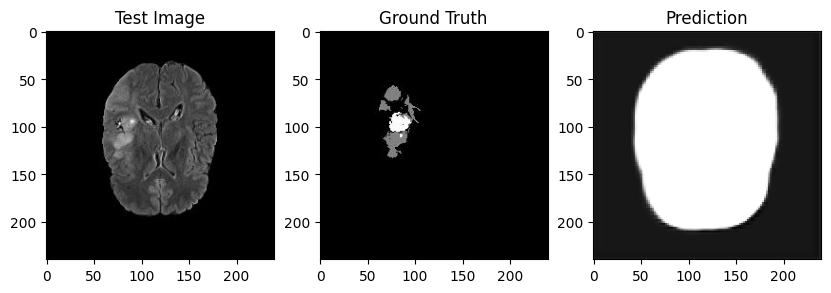

In [ ]:
import matplotlib.pyplot as plt

# load the test image, ground truth, and prediction
dir = os.path.join(TRAIN_DATASET_PATH_P, 'test', '010')


test_image = np.array(Image.open(os.path.join(dir,'flair.jpg')).convert('L').resize((IMG_HEIGHT, IMG_WIDTH)))
test_seg = np.array(Image.open(os.path.join(dir,'seg.jpg')).convert('L').resize((IMG_HEIGHT, IMG_WIDTH)))
pred_seg = model.predict(np.expand_dims(test_image, axis=0))[0]

# plot the test image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(test_image, cmap='gray')
axs[0].set_title('Test Image')

axs[1].imshow(test_seg, cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(pred_seg, cmap='gray')
axs[2].set_title('Prediction')

plt.show()

# Take 3 Using lung data

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Flatten

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 240, 240, 1
NUM_CLASSES = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.Flatten(y_true)
    y_pred_f = K.Flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_407 (Conv2D)            (None, 512, 512, 32  320         ['input_28[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_408 (Conv2D)            (None, 512, 512, 32  9248        ['conv2d_407[0][0]']             
                                )                                                          

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])


# create a data generator for training, validation, and testing data
data_gen = ImageDataGenerator(rescale=1./255)

train_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'train'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=32,
                                          class_mode='input')

valid_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'validation'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=32,
                                          class_mode='input')

test_data = data_gen.flow_from_directory(os.path.join(TRAIN_DATASET_PATH_P, 'test'),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='grayscale',
                                          batch_size=1,
                                          class_mode=None)

# loss_history = model.fit(x = train_vol,
#                        y = train_seg,
#                          batch_size = 16,
#                   epochs = 50,
#                   validation_data =(test_vol,test_seg) ,
#                   callbacks=callbacks_list)

# train the model
history = model.fit(train_data, steps_per_epoch = 526 // 32,  epochs=3, validation_data=valid_data)

Found 526 images belonging to 263 classes.
Found 60 images belonging to 30 classes.
Found 150 images belonging to 75 classes.
Epoch 1/3


AttributeError: in user code:

    File "c:\Users\hunte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\hunte\AppData\Local\Temp\ipykernel_31512\3101524873.py", line 19, in dice_coef_loss  *
        return -dice_coef(y_true, y_pred)
    File "C:\Users\hunte\AppData\Local\Temp\ipykernel_31512\3838270802.py", line 13, in dice_coef  *
        y_true_f = K.Flatten(y_true)

    AttributeError: module 'tensorflow.keras.backend' has no attribute 'Flatten'


In [ ]:
import matplotlib.pyplot as plt

# load the test image, ground truth, and prediction
dir = os.path.join(TRAIN_DATASET_PATH_P, 'test', '010')


test_image = np.array(Image.open(os.path.join(dir,'flair.jpg')).convert('L').resize((IMG_HEIGHT, IMG_WIDTH)))
test_seg = np.array(Image.open(os.path.join(dir,'seg.jpg')).convert('L').resize((IMG_HEIGHT, IMG_WIDTH)))
pred_seg = model.predict(np.expand_dims(test_image, axis=0))[0]

# plot the test image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(test_image, cmap='gray')
axs[0].set_title('Test Image')

axs[1].imshow(test_seg, cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(pred_seg, cmap='gray')
axs[2].set_title('Prediction')

plt.show()